**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [1]:
import warnings
warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance,WTICO_USD:oanda,XAU_USD:oanda',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)
#调用模块
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)
Gap30 = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

2.9299135208129883
Initialize dataview success.
Initialize dataview success.


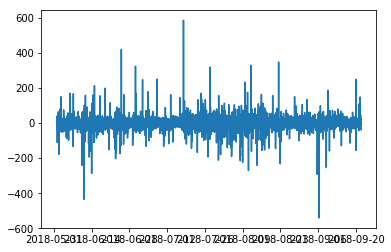

In [2]:
#30min的图
import matplotlib.pyplot as plt
plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

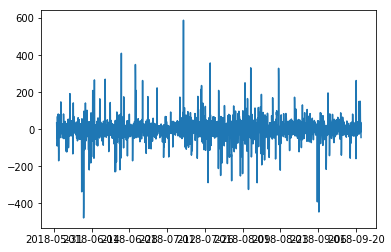

In [3]:
#1H的图
import matplotlib.pyplot as plt
plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

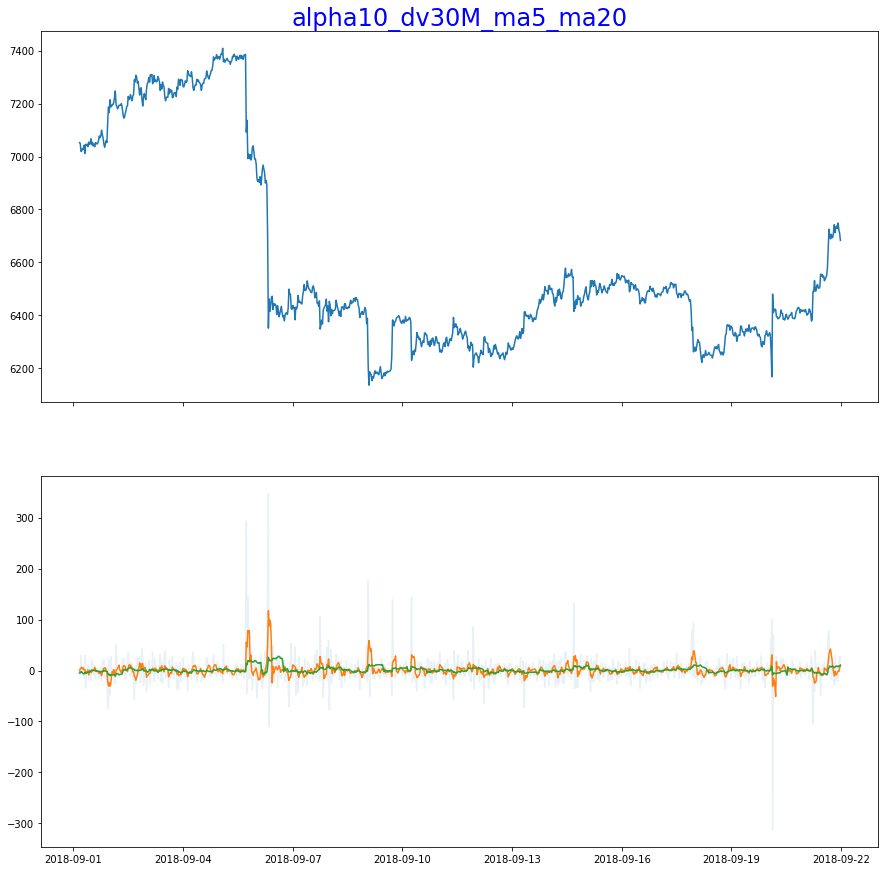

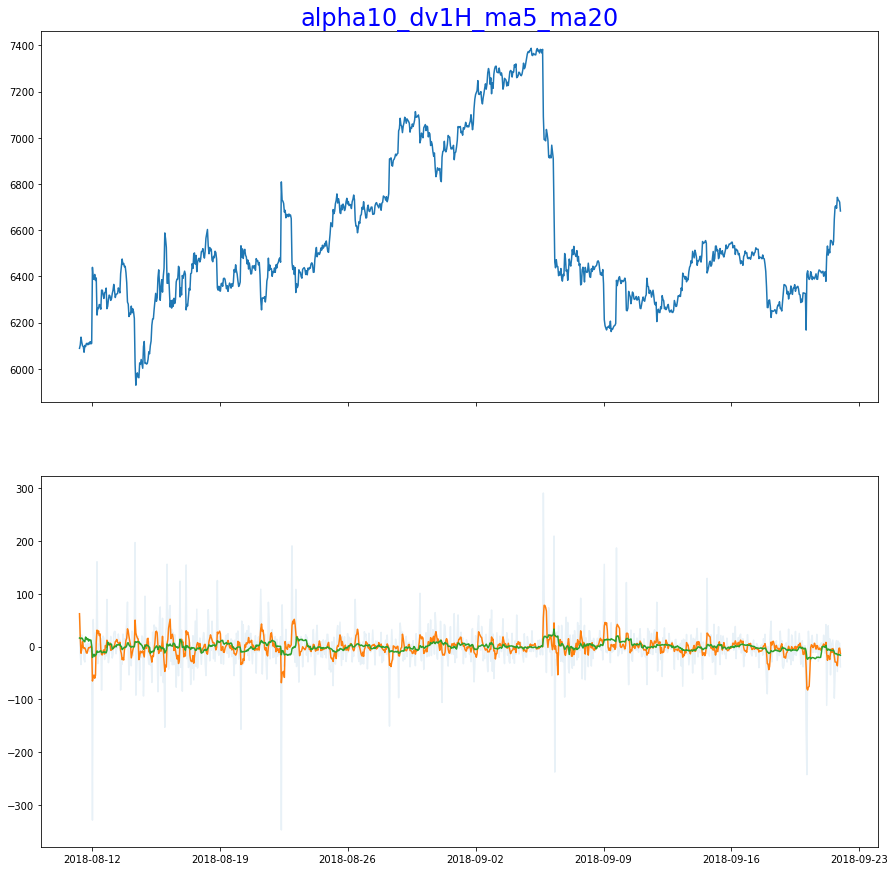

In [6]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha10_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}
# alpha10_dict
import pandas as pd
#alpha10_dv30M是30分钟线，1H是1小时线，ma5和ma20代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha10_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)#橘色短线 绿色长线

In [7]:
# 进场信号
long = dv1H.add_formula("longAlpha10","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha10","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha10","If(shortAlpha10==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha10","If(longAlpha10==2,-1,0)", add_data=True)
dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [8]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
from jaqs_fxdayu.research import TimingDigger
tdAlpha10 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha010')
TimingSignal(tdAlpha10, dv1H,'longAlpha10','shortAlpha10','closeLongAlpha10','closeShortAlpha10', 100, 0.05, 0.3)

C:\Users\TC\Anaconda3\lib\site-packages\jaqs\research\signaldigger\plotting.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\TC\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\TC\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\TC\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\TC\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\TC\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\TC\Anac

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [9]:
tdAlpha10.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [11]:
import matplotlib.pyplot as plt
import mpl_finance as mpf
    
Morning_Star = dv1H.add_formula('Morning_Star',"If((Ta('CDLMORNINGSTAR',0, open, high, low, close,volume)==100),100,0)",add_data=True)
Morning_Star = dv1H.get_ts('Morning_Star', date_type='datetime')
Morning_Star[Morning_Star['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


Initialize dataview success.


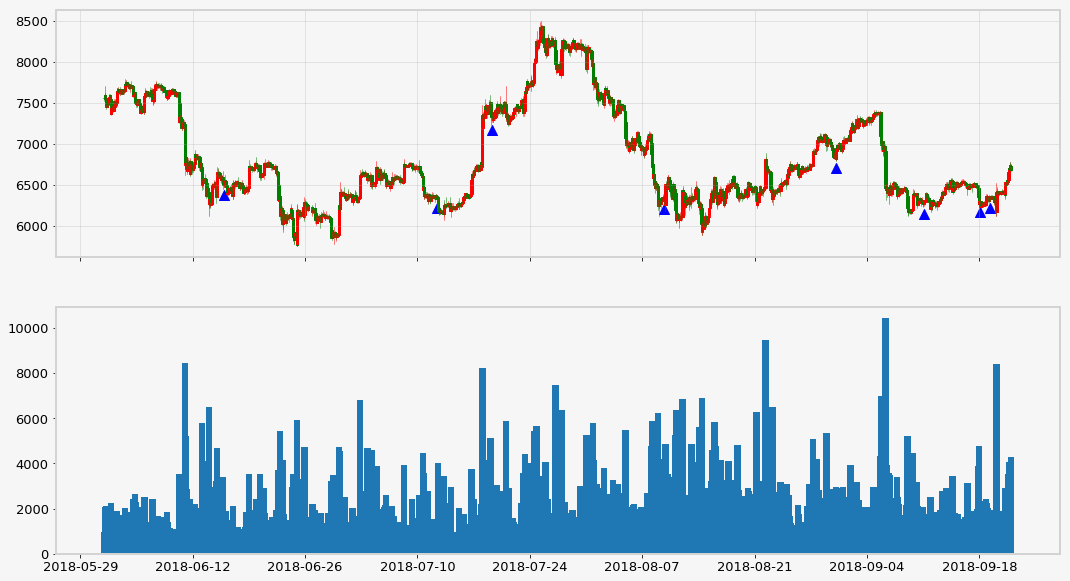

In [12]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
data1H = Time_dict.set_index('datetime')
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Morning_StarX = Morning_Star[Morning_Star['BTCUSDT:binance']==100].index
Morning_StarY = data1H.loc[Morning_StarX].low-100

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()
    
from matplotlib.pylab import date2num
data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values
draw_candle(candle, Morning_StarX, Morning_StarY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [13]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from jaqs_fxdayu.data.dataservice import LocalDataService
from time import time
warnings.filterwarnings('ignore')
ds = LocalDataService()

## 加freq参数
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '30min,1h',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path, props)#读取数据

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1h = HFDataView()
dv1h.create_init_dv(Time_dict['1h'].dropna().set_index(["trade_date","symbol"]))

##因子一：MTM
def Plot_Mean(dv, MTM, chart_name='MTM',ShortPeriod=20, LongPeriod=60,n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(MTM.iloc[n:], alpha=0.4)
    ax1.plot(MA_3.iloc[n:],alpha=0.4)
    ax1.plot(MA_6.iloc[n:],alpha=0.4)
    ax1.plot(MA_12.iloc[n:],alpha=0.4)
    ax1.plot(MA_24.iloc[n:],alpha=0.4)
    ax1.hlines(0, MTM.iloc[n:].index[0], MTM.iloc[n:].index[-1], alpha=1, linestyle='--')
    plt.ylim(5700,7500)
    # plt.savefig(chart_name)
    plt.show()

dv1h.add_formula('MA_3',"Ta('MA',0,0,0,0,close,0,3)",add_data=True)
dv1h.add_formula('MA_6',"Ta('MA',0,0,0,0,close,0,6)",add_data=True)
dv1h.add_formula('MA_12',"Ta('MA',0,0,0,0,close,0,12)",add_data=True)
dv1h.add_formula('MA_24',"Ta('MA',0,0,0,0,close,0,24)",add_data=True)
dv1h.add_formula('MTM',"(MA_3+MA_6+MA_12+MA_24)/4",add_data=True)

Initialize dataview success.


symbol,BTCUSDT:binance
trade_date,
20180601000000,NaN
20180601010000,NaN
20180601020000,NaN
20180601030000,NaN
20180601040000,NaN
20180601050000,NaN
20180601060000,NaN
20180601070000,NaN
20180601080000,NaN


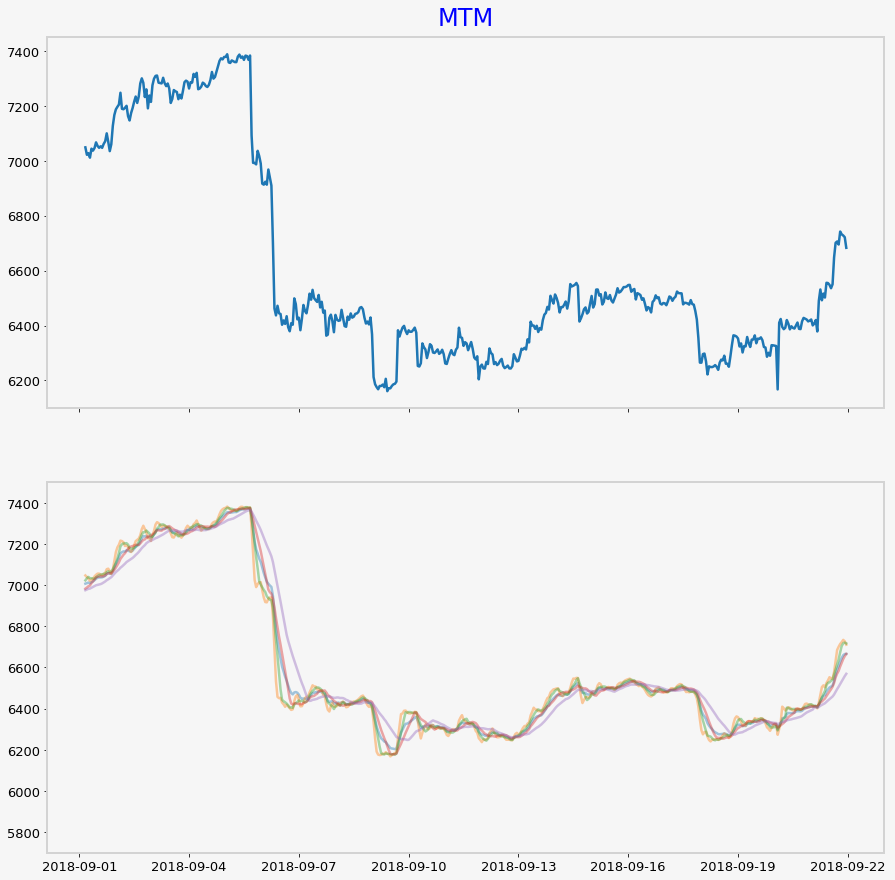

In [14]:
MA_3 = dv1h.get_ts('MA_3', date_type='datetime')
MA_6 = dv1h.get_ts('MA_6', date_type='datetime')
MA_12 = dv1h.get_ts('MA_12', date_type='datetime')
MA_24 = dv1h.get_ts('MA_24', date_type='datetime')
MTM = dv1h.get_ts('MTM', date_type='datetime')

Plot_Mean(dv1h, MTM.iloc[:,0],n=-500)

In [15]:
##因子二：KDJ
def Plot_Mean(dv, KDJ_K_A, KDJ_D_A, KDJ_J_A, chart_name='KDJ',ShortPeriod=20, LongPeriod=60,n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(KDJ_K_A.iloc[n:], alpha=0.4)
    ax1.plot(KDJ_D_A.iloc[n:], alpha=0.4)
    ax1.plot(KDJ_J_A.iloc[n:], alpha=0.4)
    ax1.hlines(0, RSV.iloc[n:].index[0], RSV.iloc[n:].index[-1], alpha=0.4, linestyle='--')
    # plt.savefig(chart_name)
    plt.show()

def SMA(A,n,m):
        # 设置alpha的比例
        alpha = m/n
        #通过ewm计算递归函数
        return A.ewm(alpha=alpha, adjust=False).mean()
dv1h.add_formula('RSV',"(close-Ts_Min(low,9))/(Ts_Max(high,9)-Ts_Min(low,9))",add_data=True)
dv1h.add_formula('KDJ_K_A',"SMA(RSV,{},{})".format(3,1), add_data=True,register_funcs={"SMA":SMA})
dv1h.add_formula('KDJ_D_A',"SMA(KDJ_K_A,{},{})".format(3,1), add_data=True,register_funcs={"SMA":SMA})
dv1h.add_formula('KDJ_J_A',"{}*KDJ_K_A - {}*KDJ_D_A".format(3,2), add_data=True)

symbol,BTCUSDT:binance
trade_date,
20180601000000,NaN
20180601010000,NaN
20180601020000,NaN
20180601030000,NaN
20180601040000,NaN
20180601050000,NaN
20180601060000,NaN
20180601070000,NaN
20180601080000,0.350145


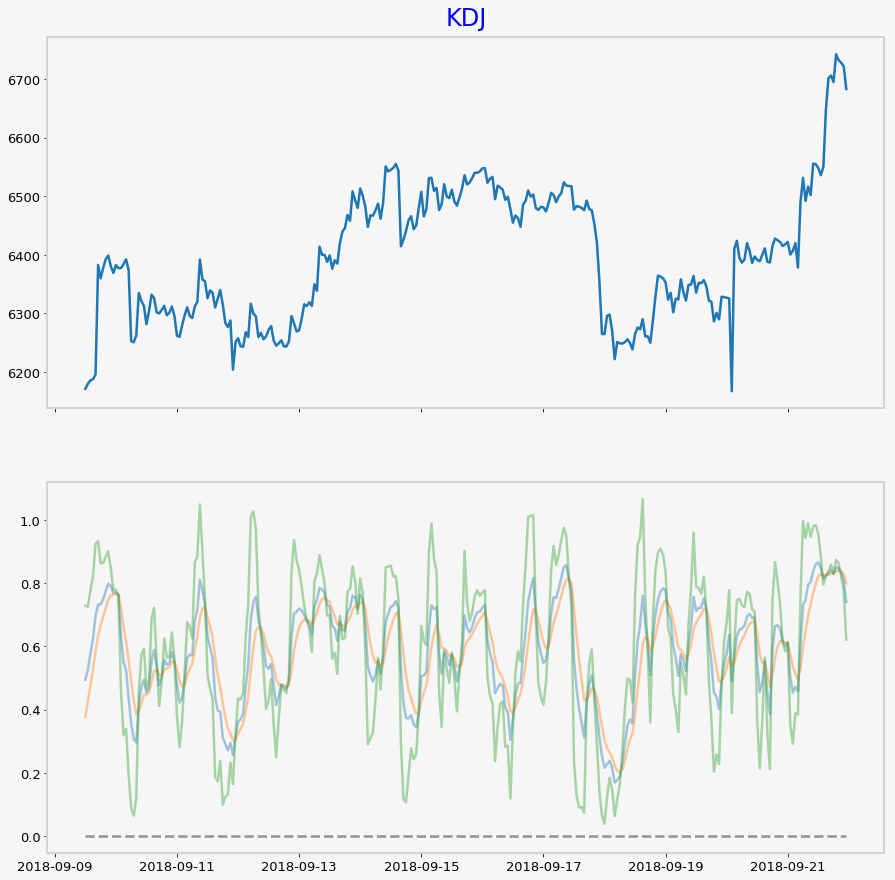

In [16]:
KDJ_K_A = dv1h.get_ts('KDJ_K_A', date_type='datetime')
KDJ_D_A = dv1h.get_ts('KDJ_D_A', date_type='datetime')
KDJ_J_A = dv1h.get_ts('KDJ_J_A', date_type='datetime')
RSV = dv1h.get_ts('RSV', date_type='datetime')

Plot_Mean(dv1h, KDJ_K_A.iloc[:,0], KDJ_D_A.iloc[:,0], KDJ_J_A.iloc[:,0], n=-300)

（1）MTM与KDJ走势均与价格走势相似，呈正相关
（2）KDJ指标橘色短线由上向下穿过绿色长线时为买入信号，反之为卖出信号

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

MTM因子：
与价格趋势相关
收盘价由下向上突破多空线时为买入信号，反之为卖出信号

KDJ因子：
与价格趋势相关
橘色短线由上向下穿过绿色长线时为买入信号，反之为卖出信号

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来
